In [1]:
from zoish.feature_selectors.optunashap import OptunaShapFeatureSelector
import xgboost
from optuna.pruners import HyperbandPruner
from optuna.samplers._tpe.sampler import TPESampler
from sklearn.model_selection import KFold,train_test_split
import pandas as pd
from sklearn.pipeline import Pipeline
from feature_engine.imputation import (
    CategoricalImputer,
    MeanMedianImputer
    )
from category_encoders import OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import (
    r2_score
    )
from zoish.utils.helper_funcs import catboost
import matplotlib.pyplot as plt
import optuna
import logging
from sklearn.model_selection import StratifiedKFold

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
[I 2022-08-09 16:06:26,071] A new study created in memory with name: no-name-70dbb20a-1130-4c45-9bb3-e35e9b0ca1de


<Figure size 432x288 with 0 Axes>

# Example 1 :Computer Hardware Data Set (a regression problem)
  
https://archive.ics.uci.edu/ml/datasets/Computer+Hardware

In [2]:
urldata= "https://archive.ics.uci.edu/ml/machine-learning-databases/cpu-performance/machine.data"
# column names
col_names=[
    "vendor name",
    "Model Name",
    "MYCT",
    "MMIN",
    "MMAX",
    "CACH",
    "CHMIN",
    "CHMAX",
    "PRP"
]
# read data
data = pd.read_csv(urldata,header=None,names=col_names,sep=',')
data

,vendor name,Model Name,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX,PRP
adviser,32/60,125,256,6000,256,16,128,198,199
amdahl,470v/7,29,8000,32000,32,8,32,269,253
amdahl,470v/7a,29,8000,32000,32,8,32,220,253
amdahl,470v/7b,29,8000,32000,32,8,32,172,253
amdahl,470v/7c,29,8000,16000,32,8,16,132,132
...,...,...,...,...,...,...,...,...,...
sperry,80/8,124,1000,8000,0,1,8,42,37
sperry,90/80-model-3,98,1000,8000,32,2,8,46,50
sratus,32,125,2000,8000,0,2,14,52,41
wang,vs-100,480,512,8000,32,0,0,67,47


# Train test split

In [3]:
X = data.loc[:, data.columns != "PRP"]
y = data.loc[:, data.columns == "PRP"]


X_train, X_test, y_train, y_test =train_test_split(X, y, test_size=0.33, random_state=42)


# Find feature types for later use

In [4]:
int_cols =  X_train.select_dtypes(include=['int']).columns.tolist()
float_cols =  X_train.select_dtypes(include=['float']).columns.tolist()
cat_cols =  X_train.select_dtypes(include=['object']).columns.tolist()


#  Define Feature selector and set its arguments  

In [5]:
optuna_regression_xgb = OptunaShapFeatureSelector(
        # general argument setting        
        verbose=1,
        random_state=0,
        logging_basicConfig = logging.basicConfig(
        level=logging.DEBUG,
        filename=None, 
        filemode='w', 
        format='%(name)s - %(levelname)s - %(message)s'
        ),
        # general argument setting        
        n_features=4,
        list_of_obligatory_features_that_must_be_in_model=[],
        list_of_features_to_drop_before_any_selection=[],
        # shap argument setting        
        estimator=catboost.CatBoostRegressor(),
        estimator_params={
        # desired lower bound and upper bound for depth
                   'depth'         : [6,10],
#                   # desired lower bound and upper bound for depth
                   'learning_rate' : [0.05, 0.1], 
        },
        # shap arguments
        model_output="raw", 
        feature_perturbation="interventional", 
        algorithm="auto", 
        shap_n_jobs=-1, 
        memory_tolerance=-1, 
        feature_names=None, 
        approximate=False, 
        shortcut=False, 
        plot_shap_summary=False,
        save_shap_summary_plot=True,
        path_to_save_plot = './summary_plot.png',
        shap_fig = plt.figure(),
        ## optuna params
        test_size=0.33,
        with_stratified = False,
        performance_metric = 'r2',
        # optuna study init params
        study = optuna.create_study(
            storage = None,
            sampler = TPESampler(),
            pruner= HyperbandPruner(),
            study_name  = None,
            direction = "maximize",
            load_if_exists = False,
            directions  = None,
        ),
        # optuna optimization params
        study_optimize_objective = None,
        study_optimize_objective_n_trials=10, 
        study_optimize_objective_timeout=600,
        study_optimize_n_jobs = -1,
        study_optimize_catch= (),
        study_optimize_callbacks = None,
        study_optimize_gc_after_trial = False,
        study_optimize_show_progress_bar=False,

)

# SFC_CATREG_OPTUNA = ScallyShapFeatureSelector(
#         n_features=5,
#         estimator=catboost.CatBoostRegressor(),
#         estimator_params={
#                   # desired lower bound and upper bound for depth
#                   'depth'         : [6,10],
#                   # desired lower bound and upper bound for depth
#                   'learning_rate' : [0.05, 0.1],  
#                     },
#         hyper_parameter_optimization_method="optuna",
#         shap_version="v0",
#         measure_of_accuracy="r2",
#         list_of_obligatory_features=[],
#         test_size=0.33,
#         cv=KFold(n_splits=3, random_state=42, shuffle=True),
#         with_shap_summary_plot=True,
#         with_stratified=False,
#         verbose=0,
#         random_state=42,
#         n_jobs=-1,
#         n_iter=100,
#         eval_metric=None,
#         number_of_trials=20,
#         sampler=TPESampler(),
#         pruner=HyperbandPruner(),
#     )


[I 2022-08-09 16:06:26,666] A new study created in memory with name: no-name-d473699f-0b3d-4045-b08a-48846c5e2e7a
root - INFO - Setting value for logging_basicConfig
root - INFO - Setting value for verbose
root - INFO - Setting value for random_state
root - INFO - Setting value for n_features
root - INFO - Setting value for list_of_obligatory_features_that_must_be_in_model
root - INFO - Setting value for list of features to drop before any selection
root - INFO - Setting value for estimator
root - INFO - Getting value for estimator
root - INFO - <catboost.core.CatBoostRegressor object at 0x10fcc7df0>
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - 

<Figure size 432x288 with 0 Axes>

# Build sklearn Pipeline

In [6]:


pipeline =Pipeline([
            # int missing values imputers
            ('intimputer', MeanMedianImputer(
                imputation_method='median', variables=int_cols)),
            # category missing values imputers
            ('catimputer', CategoricalImputer(variables=cat_cols)),
            #
            ('catencoder', OrdinalEncoder()),
            # feature selection
            ('SFC_CATREG_OPTUNA', optuna_regression_xgb),
            # add any regression model from sklearn e.g., LinearRegression
            ('regression', LinearRegression())


 ])



# Run Pipeline

root - INFO - Getting value for estimator
root - INFO - Getting value for performance metric
root - INFO - Getting value for estimator_params
root - INFO - Getting value for verbose
root - INFO - Getting value for test_size
root - INFO - Getting value for random_state
root - INFO - Getting value for study
root - INFO - Getting value for study optimize objective
root - INFO - Getting value for study_optimize_objective_n_trials
root - INFO - Getting value for study_optimize_objective_timeout
root - INFO - Getting value for study_optimize_n_jobs
root - INFO - Getting value for study_optimize_catch
root - INFO - Getting value for study_optimize_callbacks
root - INFO - Getting value for study_optimize_gc_after_trial
root - INFO - Getting value for study_optimize_show_progress_bar
root - INFO - Getting value for with_stratified
`n_jobs` argument has been deprecated in v2.7.0. This feature will be removed in v4.0.0. See https://github.com/optuna/optuna/releases/tag/v2.7.0.


0:	learn: 82.4069995	test: 124.3947182	best: 124.3947182 (0)	total: 50.5ms	remaining: 50.5s
1:	learn: 79.4420272	test: 121.7307496	best: 121.7307496 (1)	total: 51.1ms	remaining: 25.5s
2:	learn: 76.9599469	test: 119.7457170	best: 119.7457170 (2)	total: 51.5ms	remaining: 17.1s
0:	learn: 83.0497921	test: 124.8779780	best: 124.8779780 (0)	total: 49.2ms	remaining: 49.2s
3:	learn: 74.2263995	test: 117.3467093	best: 117.3467093 (3)	total: 52ms	remaining: 12.9s
1:	learn: 80.4551988	test: 122.8062152	best: 122.8062152 (1)	total: 50ms	remaining: 24.9s
4:	learn: 71.1838981	test: 114.9449747	best: 114.9449747 (4)	total: 52.4ms	remaining: 10.4s
5:	learn: 68.9962465	test: 113.4519692	best: 113.4519692 (5)	total: 52.9ms	remaining: 8.76s
2:	learn: 78.1747477	test: 120.6721189	best: 120.6721189 (2)	total: 50.7ms	remaining: 16.8s
6:	learn: 66.4922712	test: 111.0573630	best: 111.0573630 (6)	total: 53.3ms	remaining: 7.57s
0:	learn: 83.0576817	test: 124.8821178	best: 124.8821178 (0)	total: 48.7ms	remaining

[I 2022-08-09 16:06:28,470] Trial 6 finished with value: 0.7853527700089871 and parameters: {'depth': 6, 'learning_rate': 0.09100726306929725}. Best is trial 6 with value: 0.7853527700089871.
[I 2022-08-09 16:06:28,481] Trial 0 finished with value: 0.790305207610968 and parameters: {'depth': 6, 'learning_rate': 0.06591281088490353}. Best is trial 0 with value: 0.790305207610968.


713:	learn: 0.0047245	test: 60.1345780	best: 60.1344871 (631)	total: 1.18s	remaining: 474ms
745:	learn: 0.0636398	test: 60.3315420	best: 60.3315420 (745)	total: 1.18s	remaining: 401ms
279:	learn: 1.0498168	test: 61.9407060	best: 61.9407060 (279)	total: 1.22s	remaining: 3.13s
746:	learn: 0.0633000	test: 60.3314784	best: 60.3314784 (746)	total: 1.18s	remaining: 399ms
714:	learn: 0.0046505	test: 60.1345625	best: 60.1344871 (631)	total: 1.18s	remaining: 472ms
747:	learn: 0.0629419	test: 60.3314893	best: 60.3314784 (746)	total: 1.18s	remaining: 397ms
180:	learn: 3.2519509	test: 64.3139992	best: 64.3139992 (180)	total: 1.25s	remaining: 5.67s
748:	learn: 0.0627637	test: 60.3314496	best: 60.3314496 (748)	total: 1.19s	remaining: 397ms
181:	learn: 3.1918991	test: 64.2907689	best: 64.2907689 (181)	total: 1.26s	remaining: 5.66s
749:	learn: 0.0621467	test: 60.3314451	best: 60.3314451 (749)	total: 1.19s	remaining: 398ms
175:	learn: 3.0530447	test: 64.4071203	best: 64.4071203 (175)	total: 1.26s	remai

[I 2022-08-09 16:06:29,172] Trial 2 finished with value: 0.7723516005164188 and parameters: {'depth': 7, 'learning_rate': 0.058455897879732516}. Best is trial 0 with value: 0.790305207610968.
[I 2022-08-09 16:06:29,176] Trial 7 finished with value: 0.7752463426732579 and parameters: {'depth': 7, 'learning_rate': 0.05353297758256778}. Best is trial 0 with value: 0.790305207610968.
[I 2022-08-09 16:06:29,179] Trial 5 finished with value: 0.773813153007975 and parameters: {'depth': 7, 'learning_rate': 0.09790619723309762}. Best is trial 0 with value: 0.790305207610968.


374:	learn: 0.4149619	test: 61.6151829	best: 61.6151829 (374)	total: 1.78s	remaining: 2.96s
164:	learn: 1.0966737	test: 62.3788991	best: 62.3788991 (164)	total: 486ms	remaining: 2.46s
236:	learn: 1.6298832	test: 63.6289618	best: 63.6289618 (236)	total: 1.83s	remaining: 5.91s
165:	learn: 1.0825573	test: 62.3697872	best: 62.3697872 (165)	total: 491ms	remaining: 2.46s
982:	learn: 0.0268728	test: 59.9494160	best: 59.9436690 (662)	total: 1.72s	remaining: 29.7ms
983:	learn: 0.0267287	test: 59.9494335	best: 59.9436690 (662)	total: 1.72s	remaining: 27.9ms
166:	learn: 1.0701879	test: 62.3612122	best: 62.3612122 (166)	total: 493ms	remaining: 2.46s
984:	learn: 0.0265998	test: 59.9494392	best: 59.9436690 (662)	total: 1.72s	remaining: 26.2ms
375:	learn: 0.4105030	test: 61.6139768	best: 61.6139768 (375)	total: 1.78s	remaining: 2.95s
985:	learn: 0.0264425	test: 59.9494189	best: 59.9436690 (662)	total: 1.72s	remaining: 24.4ms
167:	learn: 1.0612364	test: 62.3464998	best: 62.3464998 (167)	total: 495ms	r

[I 2022-08-09 16:06:31,102] Trial 9 finished with value: 0.7608577554538632 and parameters: {'depth': 8, 'learning_rate': 0.09038924018527658}. Best is trial 0 with value: 0.790305207610968.


925:	learn: 0.0007379	test: 61.8327562	best: 61.8326825 (591)	total: 2.02s	remaining: 161ms
501:	learn: 0.0961234	test: 63.2572182	best: 63.2572182 (501)	total: 3.51s	remaining: 3.49s
857:	learn: 0.0169427	test: 61.5141036	best: 61.5135677 (719)	total: 3.42s	remaining: 567ms
333:	learn: 0.1417213	test: 63.8951464	best: 63.8949861 (332)	total: 2.26s	remaining: 4.51s
514:	learn: 0.1017372	test: 63.0155745	best: 63.0155150 (512)	total: 3.51s	remaining: 3.31s
926:	learn: 0.0007272	test: 61.8327556	best: 61.8326825 (591)	total: 2.02s	remaining: 159ms
334:	learn: 0.1407295	test: 63.8947206	best: 63.8947206 (334)	total: 2.27s	remaining: 4.5s
515:	learn: 0.1009348	test: 63.0154169	best: 63.0154169 (515)	total: 3.52s	remaining: 3.3s
502:	learn: 0.0954694	test: 63.2572190	best: 63.2572182 (501)	total: 3.52s	remaining: 3.48s
858:	learn: 0.0168947	test: 61.5141117	best: 61.5135677 (719)	total: 3.42s	remaining: 562ms
859:	learn: 0.0167235	test: 61.5141011	best: 61.5135677 (719)	total: 3.43s	remaini

[I 2022-08-09 16:06:31,388] Trial 4 finished with value: 0.7633197833618128 and parameters: {'depth': 9, 'learning_rate': 0.05450902928613909}. Best is trial 0 with value: 0.790305207610968.


607:	learn: 0.0592026	test: 63.0123690	best: 63.0118646 (590)	total: 3.89s	remaining: 2.51s
581:	learn: 0.0528453	test: 63.2521703	best: 63.2521703 (581)	total: 3.9s	remaining: 2.8s
988:	learn: 0.0069011	test: 61.5137737	best: 61.5135677 (719)	total: 3.79s	remaining: 42.1ms
412:	learn: 0.0622106	test: 63.8818677	best: 63.8818677 (412)	total: 2.64s	remaining: 3.76s
989:	learn: 0.0068542	test: 61.5137574	best: 61.5135677 (719)	total: 3.79s	remaining: 38.3ms
608:	learn: 0.0589382	test: 63.0122456	best: 63.0118646 (590)	total: 3.89s	remaining: 2.5s
990:	learn: 0.0068144	test: 61.5137375	best: 61.5135677 (719)	total: 3.79s	remaining: 34.4ms
582:	learn: 0.0524544	test: 63.2520492	best: 63.2520492 (582)	total: 3.9s	remaining: 2.79s
413:	learn: 0.0614711	test: 63.8818512	best: 63.8818512 (413)	total: 2.65s	remaining: 3.75s
991:	learn: 0.0067517	test: 61.5137372	best: 61.5135677 (719)	total: 3.79s	remaining: 30.6ms
609:	learn: 0.0584481	test: 63.0122532	best: 63.0118646 (590)	total: 3.9s	remain

[I 2022-08-09 16:06:32,368] Trial 1 finished with value: 0.7516812595057709 and parameters: {'depth': 10, 'learning_rate': 0.0564425729520488}. Best is trial 0 with value: 0.790305207610968.
[I 2022-08-09 16:06:32,506] Trial 3 finished with value: 0.7497822593528602 and parameters: {'depth': 10, 'learning_rate': 0.05900773079273636}. Best is trial 0 with value: 0.790305207610968.


954:	learn: 0.0033726	test: 63.2486439	best: 63.2483189 (738)	total: 4.87s	remaining: 229ms
vendor name, bin=39 score 0.008411858717

MYCT, bin=4 score 0.008877883253
CHMAX, bin=31 score 0.003100131869
MMIN, bin=10 score 0.007543132473
MYCT, bin=3 score 0.009232239494
800:	learn: 0.0013049	test: 63.8776268	best: 63.8776268 (800)	total: 3.61s	remaining: 897ms
955:	learn: 0.0033377	test: 63.2486460	best: 63.2483189 (738)	total: 4.87s	remaining: 224ms
956:	learn: 0.0033293	test: 63.2486415	best: 63.2483189 (738)	total: 4.87s	remaining: 219ms
957:	learn: 0.0033221	test: 63.2486410	best: 63.2483189 (738)	total: 4.87s	remaining: 214ms
801:	learn: 0.0012907	test: 63.8776259	best: 63.8776259 (801)	total: 3.61s	remaining: 892ms
958:	learn: 0.0033147	test: 63.2486388	best: 63.2483189 (738)	total: 4.87s	remaining: 208ms
802:	learn: 0.0012846	test: 63.8776255	best: 63.8776255 (802)	total: 3.61s	remaining: 887ms
959:	learn: 0.0032899	test: 63.2486416	best: 63.2483189 (738)	total: 4.88s	remaining: 2

[I 2022-08-09 16:06:32,823] Trial 8 finished with value: 0.7447783566369324 and parameters: {'depth': 10, 'learning_rate': 0.08005387634388847}. Best is trial 0 with value: 0.790305207610968.


990:	learn: 0.0002069	test: 63.8776401	best: 63.8776143 (823)	total: 3.96s	remaining: 36ms
991:	learn: 0.0002036	test: 63.8776406	best: 63.8776143 (823)	total: 3.96s	remaining: 32ms
992:	learn: 0.0002015	test: 63.8776411	best: 63.8776143 (823)	total: 3.96s	remaining: 28ms
993:	learn: 0.0001989	test: 63.8776408	best: 63.8776143 (823)	total: 3.97s	remaining: 23.9ms
994:	learn: 0.0001966	test: 63.8776411	best: 63.8776143 (823)	total: 3.97s	remaining: 19.9ms
995:	learn: 0.0001946	test: 63.8776416	best: 63.8776143 (823)	total: 3.97s	remaining: 15.9ms
996:	learn: 0.0001914	test: 63.8776416	best: 63.8776143 (823)	total: 3.97s	remaining: 12ms
997:	learn: 0.0001879	test: 63.8776415	best: 63.8776143 (823)	total: 3.97s	remaining: 7.96ms
998:	learn: 0.0001875	test: 63.8776415	best: 63.8776143 (823)	total: 3.98s	remaining: 3.98ms
999:	learn: 0.0001842	test: 63.8776415	best: 63.8776143 (823)	total: 3.98s	remaining: 0us

bestTest = 63.87761432
bestIteration = 823

Shrink model to first 824 iterations

root - INFO - Setting value for best estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for estimator
root - INFO - Getting value for best estimator
root - INFO - Getting value for model_output
root - INFO - Getting value for feature perturbation
root - INFO - Getting value for algorithm
root - INFO - Getting value for shap_n_jobs
root - INFO - Getting value for memory_tolerance
root - INFO - Getting value for feature_names
root - INFO - Getting value for approximate
root - INFO - Getting value for shortcut


401:	learn: 0.4744866	total: 98ms	remaining: 146ms
402:	learn: 0.4729404	total: 98.4ms	remaining: 146ms
403:	learn: 0.4678149	total: 98.6ms	remaining: 146ms
404:	learn: 0.4664189	total: 98.9ms	remaining: 145ms
405:	learn: 0.4632566	total: 99.1ms	remaining: 145ms
406:	learn: 0.4619573	total: 99.4ms	remaining: 145ms
407:	learn: 0.4586840	total: 99.6ms	remaining: 145ms
408:	learn: 0.4574648	total: 99.9ms	remaining: 144ms
409:	learn: 0.4535496	total: 100ms	remaining: 144ms
410:	learn: 0.4505894	total: 100ms	remaining: 144ms
411:	learn: 0.4473166	total: 101ms	remaining: 144ms
412:	learn: 0.4444376	total: 101ms	remaining: 143ms
413:	learn: 0.4398587	total: 101ms	remaining: 143ms
414:	learn: 0.4362707	total: 101ms	remaining: 143ms
415:	learn: 0.4350321	total: 102ms	remaining: 143ms
416:	learn: 0.4306254	total: 102ms	remaining: 142ms
417:	learn: 0.4276478	total: 102ms	remaining: 142ms
418:	learn: 0.4237046	total: 102ms	remaining: 142ms
419:	learn: 0.4195548	total: 103ms	remaining: 142ms
420:	l

root - INFO - Getting value for plot shap summary
root - INFO - Getting value for save_shap_summary_plot
root - INFO - Getting value for n_features
root - INFO - Getting value for path_to_save_plot


.values =
array([[ 1.62764969,  1.35779295, 15.93476449, ...,  8.55549965,
         3.50163419, 14.36523499],
       [-0.53282987, -8.66728794, -9.58661825, ..., -5.05518775,
        -3.22947953,  0.05620394],
       [ 0.33103537,  6.38364603, -7.18785282, ..., -1.93104777,
        -3.08569692, -3.70746528],
       ...,
       [-2.25189706, -5.89896052, -4.11842752, ..., -4.8602279 ,
         2.22208438, -9.61765165],
       [-2.01540425, -5.61477944, -8.41890736, ..., -4.61926014,
         1.39347457, -2.34708543],
       [-1.92382798, -8.39315001, -7.77820421, ..., -4.93470928,
        -2.37709157, -8.17482584]])

.base_values =
array([79.10740348, 79.10740348, 79.10740348, 79.10740348, 79.10740348,
       79.10740348, 79.10740348, 79.10740348, 79.10740348, 79.10740348,
       79.10740348, 79.10740348, 79.10740348, 79.10740348, 79.10740348,
       79.10740348, 79.10740348, 79.10740348, 79.10740348, 79.10740348,
       79.10740348, 79.10740348, 79.10740348, 79.10740348, 79.10740348,
 

root - INFO - Getting value for shap_fig
Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Setting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df
root - INFO - Getting value for n_features
root - INFO - Getting value for n_features
root - INFO - Getting value for importance_df
root - INFO - Getting value for importance_df


             0          1
0  vendor name    1.18378
1   Model Name   8.197932
2         MYCT  10.740123
3         MMIN  18.810969
4         MMAX  13.767728
5         CACH   7.171362
6        CHMIN   3.627279
7        CHMAX   8.232066
   column_name shap_importance
0  vendor name         1.18378
1   Model Name        8.197932
2         MYCT       10.740123
3         MMIN       18.810969
4         MMAX       13.767728
5         CACH        7.171362
6        CHMIN        3.627279
7        CHMAX        8.232066
   column_name shap_importance
3         MMIN       18.810969
4         MMAX       13.767728
2         MYCT       10.740123
7        CHMAX        8.232066
1   Model Name        8.197932
5         CACH        7.171362
6        CHMIN        3.627279
0  vendor name         1.18378
  column_name shap_importance
3        MMIN       18.810969
4        MMAX       13.767728
2        MYCT       10.740123
7       CHMAX        8.232066


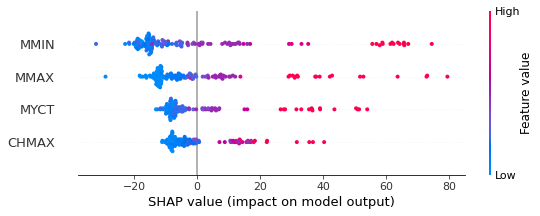

In [7]:
pipeline.fit(X_train,y_train)
y_pred = pipeline.predict(X_test)


# Check performance of the Pipeline

In [8]:
print('r2 score : ')
print(r2_score(y_test,y_pred))


r2 score : 
0.9261088019716709
